In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.backend import ones_like
from keras.layers.recurrent import GRU
from keras.layers.core import Lambda
from keras.optimizers import adam
from keras.layers import Conv1D, Dense, Reshape, Concatenate, Flatten, Activation, Dropout,MaxPooling1D
from keras.models import Input, Model
from keras_self_attention import SeqSelfAttention
from keras_multi_head import MultiHeadAttention
import numpy as np
import os
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
tf.keras.backend.clear_session()  # For easy reset of notebook state.
config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-pack

In [2]:
from keras import backend as K
from keras.layers import Layer ,Add
from keras.layers.core import Lambda


class adding_weight(Layer):

    def __init__(self, output_len, output_dim, **kwargs):
        self.output_len = output_len
        self.output_dim = output_dim
        super(adding_weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(15, self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(adding_weight, self).build(input_shape)
        
    def call(self, x):
        temp = Lambda(lambda y: K.dot(y, self.kernel))(x[1])
        temp = Lambda(lambda y: tf.expand_dims(y, 1))(temp)
        temp = Lambda(lambda y: tf.tile(y, multiples=[1, self.output_len, 1]))(temp)
        temp = Lambda(lambda y: tf.multiply(x[0], y))(temp)
        return Add()([x[0], temp])

    def compute_output_shape(self, input_shape):
        return (None, self.output_len, self.output_dim)

def local_context_learning(path_length, input_length, input_dim, output_dim, hidden_dim, filters_num, kernel_val,
                           learning_rate, drop_rate):
    basic_data_input = Input(shape=(path_length, input_length, input_dim))

    basic_input = Reshape((path_length, input_length * input_dim))(basic_data_input)

    label_data_input = Input(shape=(path_length,))

    weighted_input = adding_weight(path_length, input_length * input_dim)([basic_input, label_data_input])

    GRU_layer = GRU(units=hidden_dim, return_sequences=True)
    rnn_output = GRU_layer(weighted_input)
    Self_1 = SeqSelfAttention(attention_activation='sigmoid')
    rnn_att = Self_1(rnn_output)
    CNN_layer_1 = Conv1D(filters=filters_num, kernel_size=kernel_val, padding="same")
    cnn_output = CNN_layer_1(weighted_input)
    Dense_1 = Dense(hidden_dim)
    cnn_output_reformat = Dense_1(cnn_output)
    Self_2 = SeqSelfAttention(attention_activation='sigmoid')
    cnn_att = Self_2(cnn_output_reformat)
    Conca_1 = Concatenate(axis=1)
    new_value = Conca_1([rnn_att, cnn_att])
    new_keys = Lambda(lambda x: ones_like(x))(new_value)
    Multi_1 = MultiHeadAttention(head_num=2)
    new_result = Multi_1([weighted_input, new_keys, new_value])
    result = Flatten()(new_result)
    Drop_1 = Dropout(rate=drop_rate)
    result_fix = Drop_1(result)
    Dense_2 = Dense(output_dim)
    method_vector = Dense_2(result_fix)
    method_vector = Reshape((-1, 128))(method_vector)

    CNN_layer_2 = Conv1D(filters=filters_num, kernel_size=kernel_val, padding="same")
    cnn_output_for_classification = CNN_layer_2(method_vector)
    Pool_1 = MaxPooling1D(pool_size=2, padding='same')
    pooling_output = Pool_1(cnn_output_for_classification)
    output_classification = Flatten()(pooling_output)
    Drop_2 = Dropout(rate=drop_rate)
    output_classification_fix = Drop_2(output_classification)
    Dense_3 = Dense(32, activation='relu')
    output_classification_fix = Dense_3(output_classification_fix)
    Dense_4 = Dense(16, activation='relu')
    output_classification_fix = Dense_4(output_classification_fix)
    Dense_5 = Dense(1)
    fixed_output_classification = Dense_5(output_classification_fix)
    Active_1 = Activation(activation='sigmoid')
    stand_output = Active_1(fixed_output_classification)
    model = Model([basic_data_input, label_data_input], stand_output)
    ada = adam(lr=learning_rate)
    model.compile(optimizer=ada, loss='binary_crossentropy', metrics=['accuracy'])

    
    New_input  = Input(shape=(path_length, input_length, input_dim))
    New_input_ = Reshape((path_length, input_length * input_dim))(New_input)
    new_test_1 = GRU_layer(New_input_)
    new_test_2 = Self_1(new_test_1)
    new_test_3 = CNN_layer_1(New_input_)
    new_test_4 = Dense_1(new_test_3)
    new_test_5 = Self_2(new_test_4)
    new_test_6 = Conca_1([new_test_2, new_test_5])
    new_test_7 = Lambda(lambda x: ones_like(x))(new_test_6)
    new_test_8 = Multi_1([New_input_, new_test_7, new_test_6])
    new_test_9 = Flatten()(new_test_8)
    new_test_10 = Drop_1(new_test_9)
    new_test_11 = Dense_2(new_test_10)
    new_test_12 = Reshape((-1, 128))(new_test_11)
    new_test_13 = CNN_layer_2(new_test_12)
    new_test_14 = Pool_1(new_test_13)
    new_test_15 = Flatten()(new_test_14)
    new_test_16 = Drop_2(new_test_15)
    new_test_17 = Dense_3(new_test_16)
    new_test_18 = Dense_4(new_test_17)
    new_test_19 = Dense_5(new_test_18)
    new_test_20 = Active_1(new_test_19)
    model_test = Model(New_input, new_test_20)
    return model, model_test

In [3]:
model_local,model_local_test = local_context_learning(15, 20, 128, 128, 128, 64, 3, 0.0001, 0.5)
model_local.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 20, 128)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 15, 2560)     0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
adding_weight_1 (adding_weight) (None, 15, 2560)     38400       reshape_1[0][0]                

In [4]:
def getting_data(file_path, print_text):
    print("Loading " + print_text + " Data...")
    data = np.load(file_path,allow_pickle = True)
    print("Done")
    return data

In [5]:
input_data = getting_data("./data/local_train_input_greedy.npy", "Input")
label_data = getting_data("./data/local_train_label_greedy.npy", "Label")
output_data = getting_data("./data/local_train_output_greedy.npy", "Output")
label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [6]:
label_data.shape

(7109, 15)

In [7]:
v_input_data = getting_data("./data/local_val_input_greedy.npy", "Input")
v_label_data = getting_data("./data/local_val_label_greedy.npy", "Label")
v_output_data = getting_data("./data/local_val_output_greedy.npy", "Output")
v_label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [8]:
v_label_data.shape

(2370, 15)

In [10]:
print("Training Local Context Model...")
model_local.fit([input_data,label_data], output_data, batch_size=256, epochs=100,validation_data=([v_input_data,v_label_data], v_output_data))

Training Local Context Model...
Train on 7109 samples, validate on 2370 samples
Epoch 1/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.6919 - accuracy: 0.5323 - val_loss: 0.6857 - val_accuracy: 0.5485
Epoch 2/100
7109/7109 [==============================] - 10s 1ms/step - loss: 0.6784 - accuracy: 0.5641 - val_loss: 0.6622 - val_accuracy: 0.6308
Epoch 3/100
7109/7109 [==============================] - 10s 1ms/step - loss: 0.6588 - accuracy: 0.6246 - val_loss: 0.6439 - val_accuracy: 0.6405
Epoch 4/100
7109/7109 [==============================] - 10s 1ms/step - loss: 0.6402 - accuracy: 0.6426 - val_loss: 0.6298 - val_accuracy: 0.6582
Epoch 5/100
7109/7109 [==============================] - 10s 1ms/step - loss: 0.6192 - accuracy: 0.6715 - val_loss: 0.6319 - val_accuracy: 0.6873
Epoch 6/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.6010 - accuracy: 0.6893 - val_loss: 0.6133 - val_accuracy: 0.6907
Epoch 7/100
7109/7109 [=====================

7109/7109 [==============================] - 12s 2ms/step - loss: 0.2073 - accuracy: 0.9121 - val_loss: 0.8198 - val_accuracy: 0.7586
Epoch 57/100
7109/7109 [==============================] - 12s 2ms/step - loss: 0.2313 - accuracy: 0.9015 - val_loss: 0.8329 - val_accuracy: 0.7570
Epoch 58/100
7109/7109 [==============================] - 12s 2ms/step - loss: 0.2120 - accuracy: 0.9100 - val_loss: 0.7420 - val_accuracy: 0.7827
Epoch 59/100
7109/7109 [==============================] - 13s 2ms/step - loss: 0.2266 - accuracy: 0.9046 - val_loss: 0.7421 - val_accuracy: 0.7899
Epoch 60/100
7109/7109 [==============================] - 12s 2ms/step - loss: 0.2156 - accuracy: 0.9069 - val_loss: 0.6743 - val_accuracy: 0.7878
Epoch 61/100
7109/7109 [==============================] - 12s 2ms/step - loss: 0.2182 - accuracy: 0.9052 - val_loss: 0.7920 - val_accuracy: 0.7696
Epoch 62/100
7109/7109 [==============================] - 12s 2ms/step - loss: 0.2025 - accuracy: 0.9148 - val_loss: 0.7786 - val_a

In [11]:
model_local.save('model_greedy_adding_weight_train.h5')
model_local_test.save('model_greedy_adding_weight_test.h5')

In [12]:
t_input_data = getting_data("./data/local_test_input_greedy.npy", "Input")
t_label_data = getting_data("./data/local_test_label_greedy.npy", "Label")
t_output_data = getting_data("./data/local_test_output_greedy.npy", "Output")
t_label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [13]:
t_label_data.shape

(2356, 15)

In [14]:
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# using input lable 0s when testing

In [15]:
y_predict = model_local_test.predict(t_input_data)

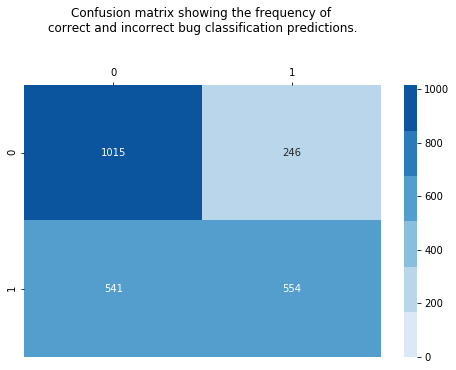

In [16]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(t_output_data, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [17]:
tn, fp, fn, tp = metrics.confusion_matrix(
    t_output_data.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)
r = tp/(tp+fn)
p = tp/(tp+fp)
f = (2*p*r)/(p+r)
acc = (tp+tn)/(tp+fp+fn+tn)

In [18]:
print("fpr_nn",fpr_nn)
print("fnr_nn",fnr_nn)
print("r",r)
print("p",p)
print("f",f)
print("acc",acc)

fpr_nn 0.3075
fnr_nn 0.3476863753213368
r 0.5059360730593607
p 0.6925
f 0.5846965699208443
acc 0.6659592529711376


In [19]:
from sklearn.metrics import  auc, roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(t_output_data, y_predict)
precision, recall, thresholds = precision_recall_curve(t_output_data, y_predict)

In [20]:
import matplotlib.pyplot as plt

auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(t_output_data, y_predict)
pr_auc = auc(recall, precision)
f1 = f1_score(t_output_data, np.rint(y_predict))
mcc = matthews_corrcoef(t_output_data, np.rint(y_predict))

In [21]:
print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.686
ROC AUC: 0.692
MCC: 0.327
F1: 0.585


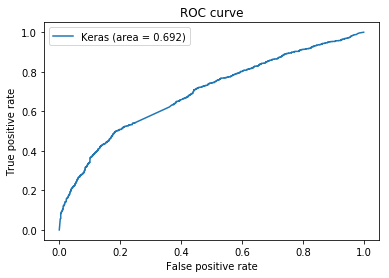

In [22]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Find the best threshold for balanced testing

In [23]:
best_f1 = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if f>best_f1:
        best_f1 = f
        print(r,p,f,acc,predict)

0.5424657534246575 0.6541850220264317 0.5931103344982526 0.6540747028862479 [0.26637256]
0.8264840182648402 0.5283129013426737 0.6445868945868946 0.5764006791171478 [0.00733054]
0.8730593607305936 0.5126005361930295 0.645945945945946 0.5551782682512734 [0.00209311]
0.863013698630137 0.5172413793103449 0.646817248459959 0.5619694397283531 [0.00290263]
0.8949771689497716 0.5072463768115942 0.6475057813016187 0.5471137521222411 [0.00106597]
0.8949771689497716 0.5077720207253886 0.6479338842975207 0.547962648556876 [0.00107214]
0.8894977168949771 0.510482180293501 0.6486846486846486 0.5522071307300509 [0.00132096]
0.8894977168949771 0.5110178384050367 0.6491169610129955 0.5530560271646859 [0.00146645]


In [24]:
best_r = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if r>best_r:
        best_r = r
        print(r,p,f,acc,predict)

0.5424657534246575 0.6541850220264317 0.5931103344982526 0.6540747028862479 [0.26637256]
0.8264840182648402 0.5283129013426737 0.6445868945868946 0.5764006791171478 [0.00733054]
0.8730593607305936 0.5126005361930295 0.645945945945946 0.5551782682512734 [0.00209311]
0.91324200913242 0.4972650422675286 0.643915003219575 0.530560271646859 [0.00053933]
0.9388127853881278 0.48605200945626476 0.6404984423676012 0.5101867572156197 [0.00013861]
0.9872146118721461 0.4695916594265856 0.636443921106859 0.47580645161290325 [2.0861626e-07]
0.9945205479452055 0.4677835051546392 0.6362839614373357 0.47156196943972833 [2.9802322e-08]
0.9963470319634703 0.46743787489288774 0.6363371245261009 0.47071307300509335 [0.]


In [25]:
best_a = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if acc>best_a:
        best_a = acc
        print(r,p,f,acc,predict)

0.5424657534246575 0.6541850220264317 0.5931103344982526 0.6540747028862479 [0.26637256]
0.5296803652968036 0.6682027649769585 0.5909322465613857 0.6591680814940577 [0.32677275]
0.4730593607305936 0.7057220708446866 0.5664297430289775 0.6634125636672326 [0.6660923]
0.5013698630136987 0.6940581542351454 0.582184517497349 0.66553480475382 [0.5279879]
0.4931506849315068 0.7003891050583657 0.5787781350482315 0.666383701188455 [0.57929605]
0.4977168949771689 0.7014157014157014 0.5822649572649573 0.668081494057725 [0.5571315]


# imbalance testing

In [26]:
im_t_input_data = getting_data("./data/local_im_test_input_greedy.npy", "Input")
im_t_label_data = getting_data("./data/local_im_test_label_greedy.npy", "Lable")
im_t_output_data = getting_data("./data/local_im_test_output_greedy.npy", "Output")
im_t_label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Lable Data...
Done
Loading Output Data...
Done


In [27]:
im_t_label_data.shape

(12423, 15)

In [28]:
im_t_input_data.shape

(12423, 15, 20, 128)

# using input lable 0s when im_testing

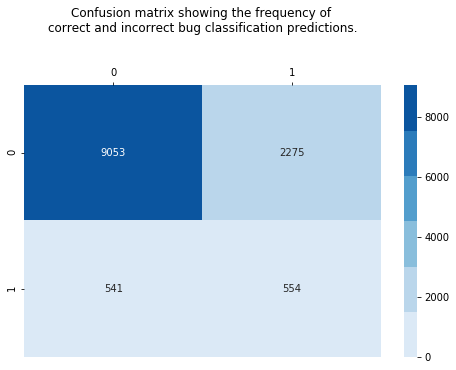

In [29]:
y_im_predict = model_local_test.predict(im_t_input_data)

confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(im_t_output_data, np.rint(y_im_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [30]:
tn, fp, fn, tp = metrics.confusion_matrix(
    im_t_output_data.astype(int), 
    np.rint(y_im_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)
r = tp/(tp+fn)
p = tp/(tp+fp)
f = (2*p*r)/(p+r)
acc = (tp+tn)/(tp+fp+fn+tn)
print("fpr_nn",fpr_nn)
print("fnr_nn",fnr_nn)
print("r",r)
print("p",p)
print("f",f)
print("acc",acc)

fpr_nn 0.8041710851891127
fnr_nn 0.056389410047946634
r 0.5059360730593607
p 0.19582891481088724
f 0.2823649337410805
acc 0.7733236738307977


# Find the best threshold for imbalanced testing

In [31]:
best_f1 = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if f>best_f1:
        best_f1 = f
        print(r,p,f,acc,predict)

0.6566210045662101 0.13609691463183798 0.22546252743806838 0.6023504789503341 [0.18575874]
0.34337899543378997 0.2363293526084224 0.279970215934475 0.8443210174676005 [0.94359183]
0.3607305936073059 0.23881499395405079 0.28737722808293925 0.842308621106013 [0.9363436]
0.4365296803652968 0.21560667568786648 0.2886473429951691 0.8103517668840055 [0.79344785]
0.43105022831050227 0.2203548085901027 0.2916280506641952 0.8154230057152057 [0.81918263]
0.4273972602739726 0.222011385199241 0.2922260380892913 0.8175158979312566 [0.8263275]
0.42648401826484017 0.22238095238095237 0.29233176838810637 0.8179988730580375 [0.8317939]
0.43105022831050227 0.22149225715626467 0.2926224426534408 0.8163084601143041 [0.8222585]
0.43105022831050227 0.2215962441314554 0.29271317829457366 0.8163889559687676 [0.8224977]
0.43105022831050227 0.2217003287928605 0.2928039702233251 0.816469451823231 [0.8226485]
0.43105022831050227 0.22180451127819548 0.2928948184920881 0.8165499476776946 [0.8226491]


In [32]:
best_a = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if acc>best_a:
        best_a = acc
        print(r,p,f,acc,predict)

0.6566210045662101 0.13609691463183798 0.22546252743806838 0.6023504789503341 [0.18575874]
0.34337899543378997 0.2363293526084224 0.279970215934475 0.8443210174676005 [0.94359183]
0.3415525114155251 0.23746031746031745 0.2801498127340824 0.8452869677211624 [0.945668]
0.291324200913242 0.2446319018404908 0.2659441433930804 0.8582468002897851 [0.9743047]
0.18356164383561643 0.27088948787061995 0.21883505715841045 0.8844884488448845 [0.99766976]
0.14703196347031963 0.2937956204379562 0.19598295800365187 0.893664976253723 [0.9993663]
0.07123287671232877 0.43333333333333335 0.12235294117647058 0.909925138855349 [0.99999785]
0.06575342465753424 0.4444444444444444 0.11455847255369929 0.91040811398213 [0.99999905]
0.0547945205479452 0.4878048780487805 0.09852216748768472 0.9116155517990824 [0.99999976]
0.04657534246575343 0.5204081632653061 0.08549874266554904 0.9121790227803268 [0.9999999]
0.045662100456621 0.5376344086021505 0.08417508417508418 0.9124205103437173 [0.99999994]


In [33]:
best_r = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if r>best_r:
        best_r = r
        print(r,p,f,acc,predict)

0.6566210045662101 0.13609691463183798 0.22546252743806838 0.6023504789503341 [0.18575874]
0.8730593607305936 0.10344081367669336 0.18496662474605785 0.3218224261450535 [0.00201583]
0.94337899543379 0.09637093012407874 0.1748772642627391 0.21532641068984948 [0.00012231]
0.9881278538812786 0.08925183535428524 0.16371614465123316 0.11019882476052484 [1.4901161e-07]
0.9926940639269406 0.0891422010824996 0.16359394988336218 0.10528857763825163 [5.9604645e-08]
0.9963470319634703 0.08909031520496488 0.16355595532568773 0.10174676004185784 [0.]
